# Load Dataset

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Feature Engineering Modules
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

# Deep Learning Modules
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

data = pd.read_csv('datafinal.csv')[
    ['flair', 'id', 'combined_features']
].rename(columns={'combined_features': 'text'})
data

,flair,id,text
0,AskIndia,fwjdqr,4 days ago pending orders 100 million hydroxyc...
1,AskIndia,fizkkk,randians big time users dating apps like tinde...
2,AskIndia,f25vx0,r india thinks flat earthershavent found india...
3,AskIndia,dtvliq,people left 9 5 jobs pursue career music art f...
4,AskIndia,b7pvwt,somebody want kill full familycalm downgo sp o...
...,...,...,...
1213,Coronavirus,fxxxrn,actual coronavirus cases least four times repo...
1214,Coronavirus,fy7ut2,donate helping coronavirusstate government fun...
1215,Coronavirus,fxul63,youth beaten female doctors attacked delhi pre...
1216,Coronavirus,fy3n43,coronavirus centre concerned polarisation reli...


# Encode the Labels

In [56]:
le = LabelEncoder()
le.fit(data['flair'])
data['n_flair'] = le.transform(data['flair'])
data.head()

,flair,id,text,n_flair
0,AskIndia,fwjdqr,4 days ago pending orders 100 million hydroxyc...,1
1,AskIndia,fizkkk,randians big time users dating apps like tinde...,1
2,AskIndia,f25vx0,r india thinks flat earthershavent found india...,1
3,AskIndia,dtvliq,people left 9 5 jobs pursue career music art f...,1
4,AskIndia,b7pvwt,somebody want kill full familycalm downgo sp o...,1


# Explore Data
## Collect Key Metrics

In [57]:
n_samples = len(data)
n_classes = len(list(set(data['flair'])))
n_samples_per_class = data['flair'].value_counts().to_dict()
median_words_per_sample = [
    np.median(
        data[data['flair'] == f]['text'].str.len()
    ) for f in list(set(data['flair']))]
                                                                                                  
print(f'Number of samples: {n_samples}')
print('--')
print(f'Number of classes: {n_classes}')
print('--')
print('Number of samples per class:')
for key, value in n_samples_per_class.items():
    print(f'    {key}: {value}')
print('--')
print(f'Median length of text:')
for c, l in list(zip(list(
    set(data['flair'])), median_words_per_sample)):
    print(f'    {c}: {l}')

Number of samples: 1218
--
Number of classes: 13
--
Number of samples per class:
    Science/Technology: 100
    Food: 100
    Coronavirus: 100
    Scheduled: 100
    Sports: 100
    Photography: 100
    AMA: 100
    AskIndia: 100
    Policy/Economy: 100
    Business/Finance: 100
    Non-Political: 100
    Politics: 100
    [R]eddiquette: 18
--
Median length of text:
    Politics: 1134.0
    Non-Political: 711.5
    Food: 992.5
    Business/Finance: 2665.0
    Science/Technology: 1376.0
    Sports: 1108.0
    AMA: 3171.5
    Coronavirus: 365.5
    [R]eddiquette: 1410.0
    Scheduled: 1188.5
    Photography: 524.5
    Policy/Economy: 2485.5
    AskIndia: 1314.0


## Plot Frequency Distribution of N-Grams

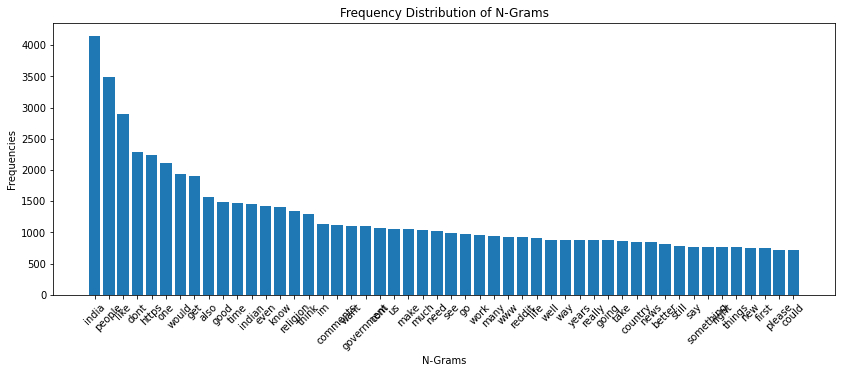

In [58]:
def plot_ngrams(sample_texts, ngram_range=(1, 2), n_ngrams=50):
    """Plots the frequency distribution of n-grams.
    
    Parameters
    ----------
    sample_texts : list
        Sample texts
    ngram_range : tuple
        The range of n-gram values to consider.
    n_ngrams : int
        Number of n-grams to plot
    """
    # Create arguments for vectorizing
    kwargs = {
        'ngram_range': (1, 1),
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': 'word'
    }
    
    cv = CountVectorizer(**kwargs)
    
    # Create vocabulary (dict, with keys as n-grams and values as
    # indices). Converts every text to array length of vocabulary,
    # the elements of which are the count of each n-gram
    vectorized_texts = cv.fit_transform(sample_texts)
    all_ngrams = list(cv.get_feature_names())
    n_ngrams = min(n_ngrams, len(all_ngrams))
    
    # Add up counts per n-gram, one row per n-gram, hence axis=0
    counts = vectorized_texts.sum(axis=0).tolist()[0]
    
    # Sort n-grams and counts by freq. and get top n n-grams
    counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
    zip(counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:n_ngrams]
    cnts = list(counts)[:n_ngrams]
    
    idx = np.arange(n_ngrams)
    plt.figure(figsize=(14, 5))
    plt.bar(idx, cnts, width=0.8)
    plt.xlabel('N-Grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency Distribution of N-Grams')
    plt.xticks(idx, ngrams, rotation=45)

plot_ngrams(data['text'])

## Plot the Number of Words Per Sample

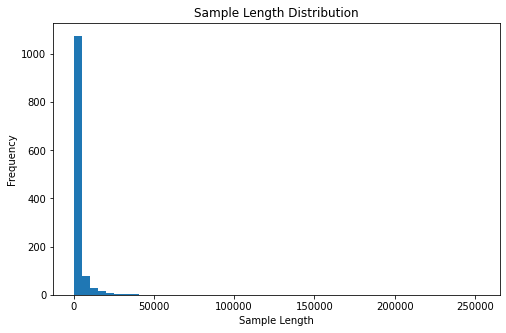

In [59]:
def plot_words_per_sample(sample_texts):
    """Plots the sample length distribution
    
    Parameters
    ----------
    sample_texts : list
        Sample texts
    
    """
    plt.figure(figsize=(8, 5))
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Sample Length')
    plt.ylabel('Frequency')
    plt.title('Sample Length Distribution')

plot_words_per_sample(data['text'])

# Choose the Model
> How do we present the text data to an algorithm that expects numeric input?

In order for us to get an idea of the complexity of the model we'll be using, we should first calculate the ratio of the number of samples to the number of words per sample.

In [60]:
# Divide two lists
ratio = [i / j for i, j in zip(median_words_per_sample, list(n_samples_per_class.values()))]
avg_ratio = sum(ratio) / len(ratio)
avg_ratio

18.79423076923077

Thankfully, this is a very small ratio compared to what we would need to build complex CNNs. We'll need to tokenize the text as sequences and classify them with a multi-layer perceptron. 
# Prepare the Data
It is good practice to shuffle our data before feeding it into a model so it won't be affected by data order. Then, we'll need to tokenize our dataset to build its vocabulary. We'll tokenize it into unigrams and bigrams, and then generate a TF-IDF vector of the length of the vocabulary.

In [67]:
data = data.sample(frac=1).reset_index(drop=True)

kwargs = {
    'ngram_range': (1, 2),
    'dtype': 'int32',
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': 'word',
    'min_df': 2 # document/corpus freq. below which a token will be discarded
}
vec = TfidfVectorizer()
X = vec.fit_transform(data['text']).toarray()
X.shape

(1218, 52354)

We have 1,218 samples, and 52,354 features extracted by the TF-IDF vectorizer.
## Feature Selection
Use the ANOVA f-value to pick the top 20,000 features from the vector of tokens.

In [68]:
TOP_K = 20000

select = SelectKBest(f_classif, k=min(TOP_K, X.shape[1]))
select.fit(X, data['n_flair'])
X = select.transform(X).astype('float32')
X.shape

(1218, 20000)

## Train/Test Split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, data['n_flair'], test_size=0.33, random_state=42)
model_data = (X_train, y_train), (X_test, y_test)

# Building and Training the Model
We are building a model that processes individual tokens (i.e., not worrying about word order). Multi-layer perceptrons typically perform best with n-gram models, so that's what we'll be building using `keras`.

In [74]:
def build_model(n_layers, units, dropout_rate, input_shape, n_classes):
    """Builds n-gram model
    
    Parameters
    ----------
    n_layers : int
        Number of Dense layers in model
    units : int
        Output dimension of layers
    dropout_rate : float
        Percentage of input to drop at Dropout layers
    input_shape : tuple
        Shape of input to the model
    n_classes : int
        Number of input classes
        
    Returns
    -------
    Fully-connected model
    """
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))
    
    for _ in range(n_layers - 1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
        
    model.add(Dense(n_classes, 'softmax'))
    return model

def train_model(data, 
                lr=0.001, 
                epochs=1000, 
                batch_size=32, 
                n_layers=2, 
                units=64, 
                dropout_rate=0.2):
    """Trains n-gram model
    
    Parameters
    ----------
    data : tuple
        Tuple containing tuples of training and testing text and labels
    learning_rate : float
        Learning rate for optimizer
    epochs : int
        Number of epochs
    batch_size : int
        # of samples per batch
    layers : int
        Number of Dense layers in model
    units : int
        Output dimension of Dense layers
    dropout_rate : float
        Percentage of input to drop at Dropout layers
    """
    (text_train, labels_train), (text_test, labels_test) = data
    n_classes = len(list(set(labels_train.append(labels_test))))
    
    # Create model instance
    model = build_model(
        n_layers=n_layers,
        units=units,
        dropout_rate=dropout_rate,
        input_shape=text_train.shape[1:],
        n_classes=n_classes
    )
    
    loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    
    # Early stopping
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]
    
    # Train and validate
    history = model.fit(
        text_train,
        labels_train,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(text_test, labels_test),
        verbose=2,
        batch_size=batch_size
    )
    
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

In [75]:
train_model(model_data)

Epoch 1/1000
26/26 - 0s - loss: 2.5487 - acc: 0.1912 - val_loss: 2.5227 - val_acc: 0.3856
Epoch 2/1000
26/26 - 0s - loss: 2.4333 - acc: 0.6618 - val_loss: 2.4381 - val_acc: 0.4925
Epoch 3/1000
26/26 - 0s - loss: 2.2422 - acc: 0.8002 - val_loss: 2.3287 - val_acc: 0.5522
Epoch 4/1000
26/26 - 0s - loss: 2.0162 - acc: 0.8701 - val_loss: 2.2079 - val_acc: 0.5697
Epoch 5/1000
26/26 - 0s - loss: 1.7544 - acc: 0.9338 - val_loss: 2.0776 - val_acc: 0.6045
Epoch 6/1000
26/26 - 0s - loss: 1.4991 - acc: 0.9301 - val_loss: 1.9496 - val_acc: 0.6244
Epoch 7/1000
26/26 - 0s - loss: 1.2462 - acc: 0.9669 - val_loss: 1.8221 - val_acc: 0.6617
Epoch 8/1000
26/26 - 0s - loss: 1.0074 - acc: 0.9694 - val_loss: 1.7143 - val_acc: 0.6716
Epoch 9/1000
26/26 - 0s - loss: 0.8237 - acc: 0.9730 - val_loss: 1.6146 - val_acc: 0.6915
Epoch 10/1000
26/26 - 0s - loss: 0.6636 - acc: 0.9681 - val_loss: 1.5333 - val_acc: 0.7040
Epoch 11/1000
26/26 - 0s - loss: 0.5553 - acc: 0.9730 - val_loss: 1.4675 - val_acc: 0.7040
Epoch 12